In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./dataset/2/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



./dataset/2/lettuce_dataset.csv
./dataset/2/lettuce_dataset_updated.csv
./dataset/2/unseen_data.csv


In [2]:
def normalize_series(data, min, max):
    data-=min
    data/=max
    return data

def windowed_dataset(series, batch_size, n_past=24, n_future=4, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past+n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past+n_future))
    ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-n_future], w[-n_future:, :1]))
    ds = ds.batch(batch_size).prefetch(shift)
    return ds

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

%matplotlib inline
warnings.filterwarnings('ignore')

In [4]:
lettuce_df = pd.read_csv('./dataset/2/lettuce_dataset.csv', encoding='latin-1')
lettuce_df.head()

,Plant_ID,Date,Temperature (°C),Humidity (%),TDS Value (ppm),pH Level,Growth Days
0,1,8/3/2023,33.4,53,582,6.4,1
1,1,8/4/2023,33.5,53,451,6.1,2
2,1,8/5/2023,33.4,59,678,6.4,3
3,1,8/6/2023,33.4,68,420,6.4,4
4,1,8/7/2023,33.4,74,637,6.5,5


In [5]:
from sklearn.preprocessing import PolynomialFeatures


features = lettuce_df.drop(columns=['Plant_ID', 'Date', 'Growth Days' ], axis=1)

# Create polynomial and interaction terms
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(features)

poly_feature_names = poly.get_feature_names_out(features.columns)

# define custom name for the features
custom_poly_names = [f'Poly_{name}' for name in poly_feature_names]

poly_df = pd.DataFrame(poly_features, columns=custom_poly_names)

poly_df.head()

,Poly_Temperature (°C),Poly_Humidity (%),Poly_TDS Value (ppm),Poly_pH Level,Poly_Temperature (°C)^2,Poly_Temperature (°C) Humidity (%),Poly_Temperature (°C) TDS Value (ppm),Poly_Temperature (°C) pH Level,Poly_Humidity (%)^2,Poly_Humidity (%) TDS Value (ppm),Poly_Humidity (%) pH Level,Poly_TDS Value (ppm)^2,Poly_TDS Value (ppm) pH Level,Poly_pH Level^2
0,33.4,53.0,582.0,6.4,1115.56,1770.2,19438.8,213.76,2809.0,30846.0,339.2,338724.0,3724.8,40.96
1,33.5,53.0,451.0,6.1,1122.25,1775.5,15108.5,204.35,2809.0,23903.0,323.3,203401.0,2751.1,37.21
2,33.4,59.0,678.0,6.4,1115.56,1970.6,22645.2,213.76,3481.0,40002.0,377.6,459684.0,4339.2,40.96
3,33.4,68.0,420.0,6.4,1115.56,2271.2,14028.0,213.76,4624.0,28560.0,435.2,176400.0,2688.0,40.96
4,33.4,74.0,637.0,6.5,1115.56,2471.6,21275.8,217.10,5476.0,47138.0,481.0,405769.0,4140.5,42.25


In [6]:
lettuce_df['Date'] = pd.to_datetime(lettuce_df['Date']).map(pd.Timestamp.toordinal)


# Integrate new features to original dataset
enhanced_df = pd.concat([lettuce_df, poly_df], axis=1)

enhanced_df = enhanced_df.drop(columns=['Plant_ID','Growth Days'])

# Number of features in dataset
N_FEATURES = enhanced_df.shape[1]

print(F'n features: {N_FEATURES}')
enhanced_df.head()


n features: 19


,Date,Temperature (°C),Humidity (%),TDS Value (ppm),pH Level,Poly_Temperature (°C),Poly_Humidity (%),Poly_TDS Value (ppm),Poly_pH Level,Poly_Temperature (°C)^2,Poly_Temperature (°C) Humidity (%),Poly_Temperature (°C) TDS Value (ppm),Poly_Temperature (°C) pH Level,Poly_Humidity (%)^2,Poly_Humidity (%) TDS Value (ppm),Poly_Humidity (%) pH Level,Poly_TDS Value (ppm)^2,Poly_TDS Value (ppm) pH Level,Poly_pH Level^2
0,738735,33.4,53,582,6.4,33.4,53.0,582.0,6.4,1115.56,1770.2,19438.8,213.76,2809.0,30846.0,339.2,338724.0,3724.8,40.96
1,738736,33.5,53,451,6.1,33.5,53.0,451.0,6.1,1122.25,1775.5,15108.5,204.35,2809.0,23903.0,323.3,203401.0,2751.1,37.21
2,738737,33.4,59,678,6.4,33.4,59.0,678.0,6.4,1115.56,1970.6,22645.2,213.76,3481.0,40002.0,377.6,459684.0,4339.2,40.96
3,738738,33.4,68,420,6.4,33.4,68.0,420.0,6.4,1115.56,2271.2,14028.0,213.76,4624.0,28560.0,435.2,176400.0,2688.0,40.96
4,738739,33.4,74,637,6.5,33.4,74.0,637.0,6.5,1115.56,2471.6,21275.8,217.10,5476.0,47138.0,481.0,405769.0,4140.5,42.25


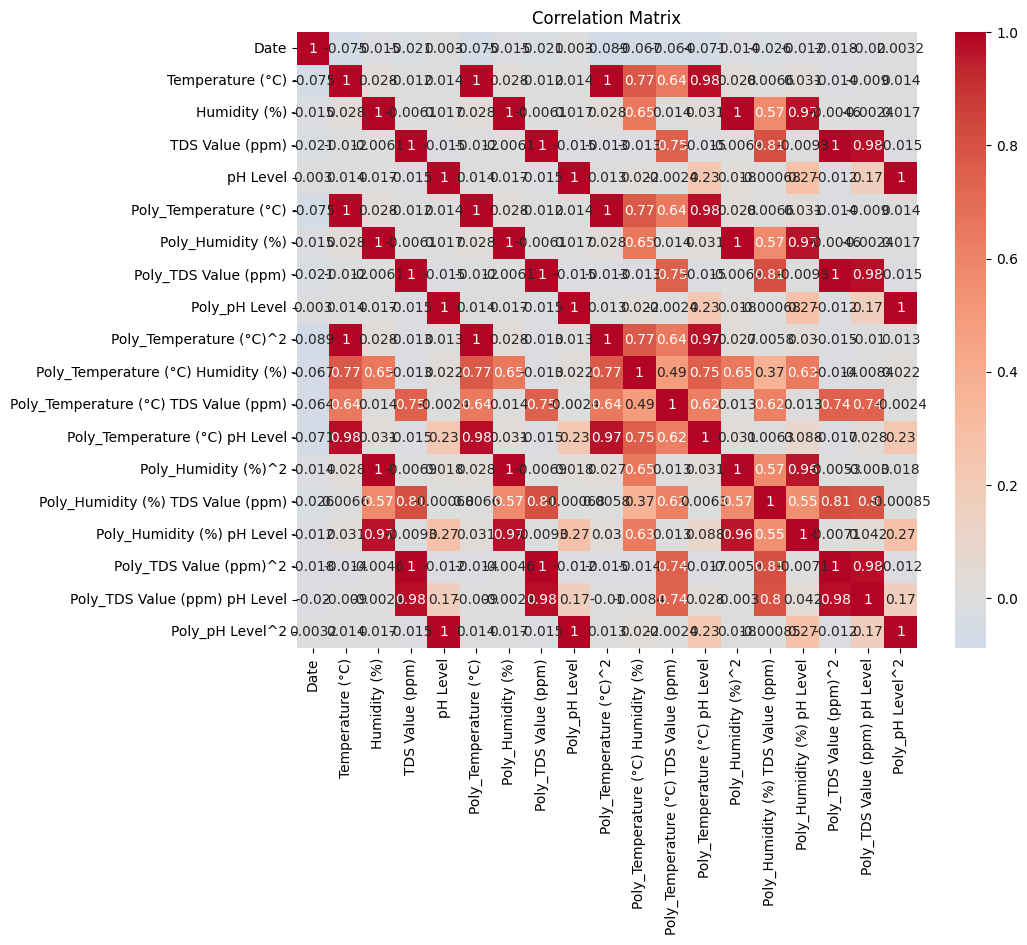

In [7]:
# Create correlation matrix
correlation_matrix = enhanced_df.corr()


# Visualize the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


In [8]:
data = enhanced_df.values
split_time = int(len(data)*0.8)
data = normalize_series(data, data.min(axis=0), data.max(axis=0))
# Add the time to harvest as a target variable in the input data
x_train = enhanced_df.values
print(f'X Train: {len(x_train)}')
y_train = lettuce_df['Growth Days'].values
print(f'Y Train: {len(y_train)}')
x_valid = enhanced_df.iloc[split_time:]
print(f'X Valid: {len(x_valid)}')
y_valid = lettuce_df.iloc[split_time:]['Growth Days']
print(f'Y Valid: {len(y_valid)}')

X Train: 3169
Y Train: 3169
X Valid: 634
Y Valid: 634


In [9]:
from tensorflow.keras.optimizers import SGD

# DO NOT CHANGE THIS
BATCH_SIZE = 32
N_PAST = 24  # Number of past time steps based on which future observations should be predicted
N_FUTURE = 24  # Number of future time steps which are to be predicted.
SHIFT = 1  # By how many positions the window slides to create a new window of observations.

# Code to create windowed train and validation datasets.
# Complete the code in windowed_dataset.
# YOUR CODE HERE
train_set = windowed_dataset(series=x_train, batch_size=BATCH_SIZE, n_past=N_PAST, n_future=N_FUTURE, shift=SHIFT)
# YOUR CODE HERE
valid_set = windowed_dataset(series=x_valid, batch_size=BATCH_SIZE, n_past=N_PAST, n_future=N_FUTURE, shift=SHIFT)

model = tf.keras.models.Sequential([
    # tf.keras.layers.LSTM(64, 'relu', return_sequences=True, input_shape=[N_PAST, N_FEATURES]),
    tf.keras.layers.Dense(64, input_shape=(N_PAST, N_FEATURES)),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(1, activation='linear'),
])

class StopWhenReachDesireMAE(tf.keras.callbacks.Callback):
    def __init__(self, monitor='mae', monitor2='val_mae', target=0.14):
        super(StopWhenReachDesireMAE, self).__init__()
        self.monitor = monitor
        self.monitor2 = monitor2
        self.target = target

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        current2 = logs.get(self.monitor2)
        if current is not None and current2 is not None:
            if current < self.target and current2 < self.target:
                print(
                    f'\nEpoch {epoch + 1}: {self.monitor} and {self.monitor2} have reached {self.target}. Stopping training.')
                self.model.stop_training = True

stop_callback = StopWhenReachDesireMAE('mae', 'val_mae', 0.05)

# # Menggunakan optimizer SGD dengan learning rate default dan momentum 0.9
optimizer = SGD(learning_rate=1e-9, momentum=0.9)
optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.0001)
# Code to train and compile the model
# YOUR CODE HERE
model.compile(
    loss='mse',
    # optimizer='adam',
    optimizer ='adam',
    metrics=['mae']
)
# model.compile(
#     loss='mse',
#     optimizer=optimizer,
#     metrics=['mae']
# )

history = model.fit(
    train_set,
    epochs=150,
    validation_data=valid_set,
    callbacks=[stop_callback]
)



Epoch 1/150


98/98 [==============================] - 1s 6ms/step - loss: 26896406528.0000 - mae: 96121.2891 - val_loss: 232412096.0000 - val_mae: 13243.9023
Epoch 2/150
98/98 [==============================] - 0s 4ms/step - loss: 29954564.0000 - mae: 3404.2412 - val_loss: 1714407.2500 - val_mae: 1104.3585
Epoch 3/150
98/98 [==============================] - 0s 4ms/step - loss: 1654085.2500 - mae: 1086.4407 - val_loss: 1595416.7500 - val_mae: 1069.3682
Epoch 4/150
98/98 [==============================] - 0s 4ms/step - loss: 1546433.5000 - mae: 1049.3253 - val_loss: 1492649.6250 - val_mae: 1031.4572
Epoch 5/150
98/98 [==============================] - 0s 4ms/step - loss: 1427551.1250 - mae: 1007.2034 - val_loss: 1365674.2500 - val_mae: 986.2070
Epoch 6/150
98/98 [==============================] - 0s 4ms/step - loss: 1303719.3750 - mae: 961.5566 - val_loss: 1235127.0000 - val_mae: 937.7484
Epoch 7/150
98/98 [==============================] - 0s 4ms/step - loss: 1176530.1250 - mae: 911

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24, 64)            1280      
                                                                 
 dense_1 (Dense)             (None, 24, 32)            2080      
                                                                 
 dense_2 (Dense)             (None, 24, 1)             33        
                                                                 
Total params: 3393 (13.25 KB)
Trainable params: 3393 (13.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


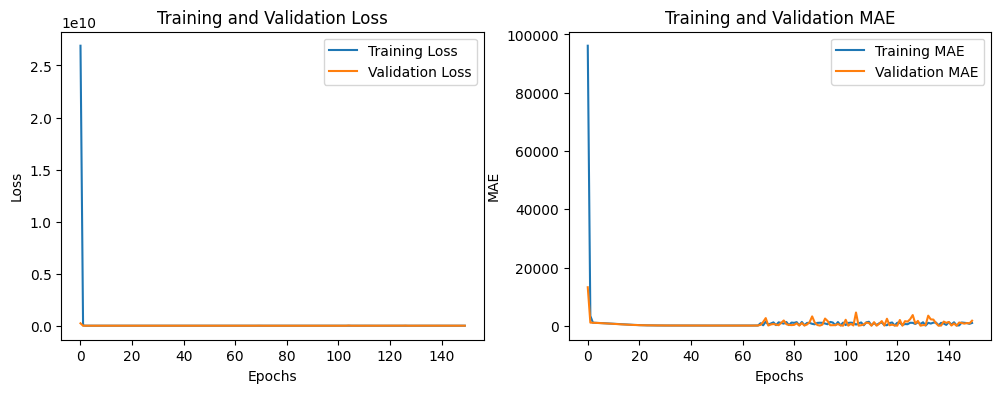

In [11]:
# Plotting training & validation loss and accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

In [12]:
print("Dimensi x_train:", x_train.shape)
# print("Dimensi input_data:", input_data.shape)


Dimensi x_train: (3169, 19)


In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

temp = 20
humid = 60
tds = 200
ph = 7
# gr = 20
dt = pd.to_datetime('2024-07-29')

dt = dt.toordinal()

print(dt)

# Create a polynomial feature matrix with appropriate number of features
degree = 1  # Adjust the degree as needed to match the expected number of features
poly_features = PolynomialFeatures(degree=degree, include_bias=False)
X = np.array([temp, humid, tds, ph, dt]).reshape(1, -1)
poly_features_matrix = poly_features.fit_transform(X)

# Check the number of features generated
n_features_generated = poly_features_matrix.shape[1]
print("Number of features generated:", n_features_generated)

# Add additional features if necessary
if n_features_generated < N_FEATURES:
    n_additional_features = N_FEATURES - n_features_generated
    additional_features = np.zeros((1, n_additional_features))
    poly_features_matrix = np.concatenate([poly_features_matrix, additional_features], axis=1)

# Repeat the polynomial feature matrix to match the model input shape
poly_features_matrix = np.repeat(poly_features_matrix, N_PAST, axis=0)

# Reshape the polynomial feature matrix to match the model input shape
poly_features_matrix = poly_features_matrix.reshape(1, N_PAST, -1)

# Make predictions using the model
predictions = model.predict(poly_features_matrix)

print(f" input testing {temp} {humid} {tds} {ph} {dt}")
print("Predictions:", predictions)

739096
Number of features generated: 5
1/1 [==============================] - 0s 19ms/step
 input testing 20 60 200 7 739096
Predictions: [[[159903.31]
  [159903.31]
  [159903.31]
  [159903.31]
  [159903.31]
  [159903.31]
  [159903.31]
  [159903.31]
  [159903.31]
  [159903.31]
  [159903.31]
  [159903.31]
  [159903.31]
  [159903.31]
  [159903.31]
  [159903.31]
  [159903.31]
  [159903.31]
  [159903.31]
  [159903.31]
  [159903.31]
  [159903.31]
  [159903.31]
  [159903.31]]]


In [14]:
export_dir = 'saved_model/mlp11'

tf.saved_model.save(model,export_dir=export_dir)

INFO:tensorflow:Assets written to: saved_model/mlp11\assets


INFO:tensorflow:Assets written to: saved_model/mlp11\assets


In [15]:
#@title Select mode of optimization
mode = "Speed" #@param ["Default", "Storage", "Speed"]

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [16]:

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert();

In [17]:
import pathlib

tflite_model_file = pathlib.Path('./saved_model/mlp11_yGRwFeaEng(wDate).tflite')
tflite_model_file.write_bytes(tflite_model)

model.save("./saved_model/h5File/mlp11_yGRwFeaEng(wDate).h5")